In [67]:
# Importar lo básico
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Para que los gráficos se vean bien
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

#TANTO EL ANALISIS EXPLORATORIO, COMO EL MODELO, HA SIDO CON AYUDA DE CHATGPT (PRINCIPALMENTE PARA LA EXTRUCTURA Y LIMPIEZA DE CODIGO), LAS TEORIAS QUE ME HAN BRINDADO, LOS PROFESORES Y LAS WEBS DE https://pandas.pydata.org/, https://seaborn.pydata.org/ (EN LA ZONA DE EJEMPLOS ME APARECIA EL CODIGO A PONER EN EL MODELO, ESTA ME SIRVIÓ MUCHO.) Y https://matplotlib.org/.

## Cargar los datos y ver que tengo

In [68]:
# Cargar datos
df = pd.read_csv('games.csv')

# Renombrar columnas (el CSV viene mal formateado)
columnas = ['Name', 'Release_date', 'Estimated_owners', 'Peak_CCU', 
            'Required_age', 'Price', 'Discount', 'DLC_count', 
            'About', 'Languages', 'Audio_lang', 'Reviews', 'Header', 
            'Website', 'Support_url', 'Support_email', 'Windows', 
            'Mac', 'Linux', 'Metacritic_score', 'Metacritic_url', 
            'User_score', 'Positive', 'Negative', 'Score_rank', 
            'Achievements', 'Recommendations', 'Notes', 'Avg_playtime',
            'Avg_playtime_2w', 'Median_playtime', 'Median_playtime_2w',
            'Developers', 'Publishers', 'Categories', 'Genres', 
            'Tags', 'Screenshots', 'Movies']
df.columns = columnas

print(f'Dataset original: {len(df)} juegos')
print(f'\nPrimeros 5 juegos:')
df[['Name', 'Price', 'Positive', 'Negative', 'Peak_CCU']].head()

Dataset original: 111452 juegos

Primeros 5 juegos:


,Name,Price,Positive,Negative,Peak_CCU
20200,Galactic Bowling,19.99,6,11,0
655370,Train Bandit,0.99,53,5,0
1732930,Jolt Project,4.99,0,0,0
1355720,Henosis™,5.99,3,0,0
1139950,Two Weeks in Painland,0.00,50,8,0


In [69]:
## PRUEBA: Veo si hay valores extraños en Price
print('Veamos los precios más raros:')
print(f'Precio máximo: ${df["Price"].max()}')
print(f'Precio mínimo: ${df["Price"].min()}')
print(f'\nJuegos gratis: {(df["Price"] == 0).sum()}')
print(f'Juegos muy caros (>$100): {(df["Price"] > 100).sum()}')

# Hay juegos de $0 y algunos de $999... mejor los filtro

Veamos los precios más raros:
Precio máximo: $999.98
Precio mínimo: $0.0

Juegos gratis: 23247
Juegos muy caros (>$100): 227


## Limpiar los datos

He visto que hay juegos gratis y otros de $999. Voy a quedarme solo con el rango normal.

In [70]:
# Al principio quité solo los gratis
df_limpio = df[df['Price'] > 0].copy()
print(f'Después de quitar gratis: {len(df_limpio)} juegos')
print(f'Precio máximo: ${df_limpio["Price"].max()}')

Después de quitar gratis: 88205 juegos
Precio máximo: $999.98


In [71]:
# Pero me acordé de que explorando vi que habian de $999 cosa que no tenia ningun sentido y me iban a desestabilizar el modelo.
# Filtro mejor, solo de $0.99 a $80. (Normalmente el precio de venta es $60 (JUEGOS TRIPLE AAA) aunque el nuevo estandar esta ya por los $80, asi que por eso decidi ese rango).
df_limpio = df[(df['Price'] >= 0.99) & (df['Price'] <= 80)].copy()

print(f'Dataset filtrado ($0.99 - $80): {len(df_limpio)} juegos')
print(f'Juegos eliminados: {len(df) - len(df_limpio)}')
print(f'\nAhora el precio máximo es: ${df_limpio["Price"].max()}')
print(f'Y el mínimo: ${df_limpio["Price"].min()}')

Dataset filtrado ($0.99 - $80): 85260 juegos
Juegos eliminados: 26192

Ahora el precio máximo es: $79.99
Y el mínimo: $0.99


## Ver cómo se distribuyen los precios

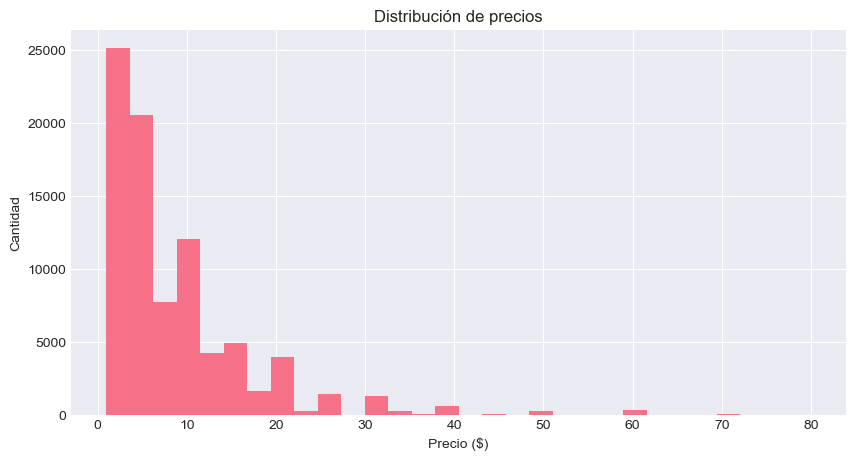

Precio promedio: $8.68
Precio mediano: $5.99


In [72]:
# Primer gráfico simple
plt.figure(figsize=(10, 5))
plt.hist(df_limpio['Price'], bins=30)
plt.xlabel('Precio ($)')
plt.ylabel('Cantidad')
plt.title('Distribución de precios')
plt.show()

print(f'Precio promedio: ${df_limpio["Price"].mean():.2f}')
print(f'Precio mediano: ${df_limpio["Price"].median():.2f}')

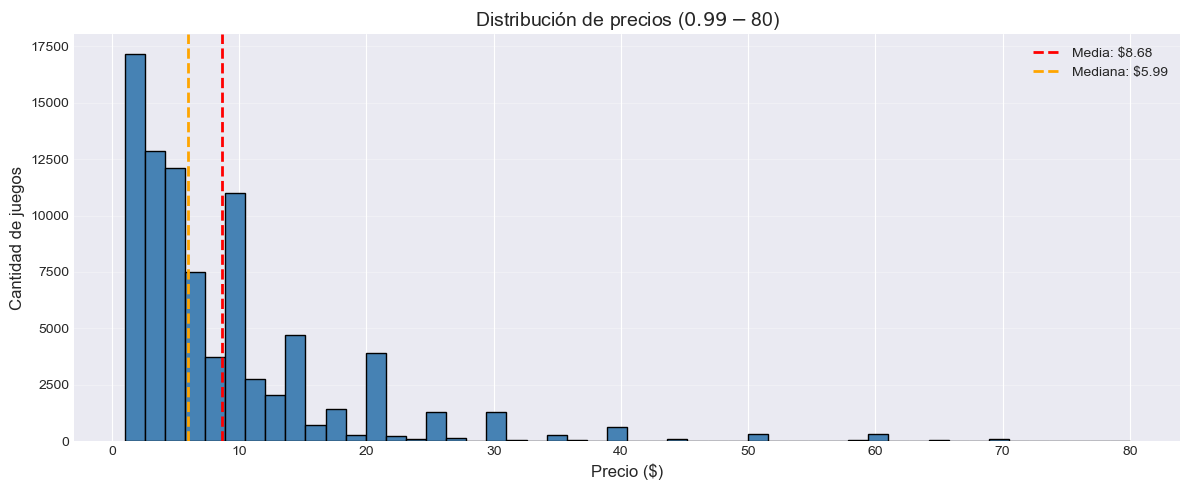

Algo mejor, ahora se ven claramente los rangos de precio más comunes.


In [73]:
# El gráfico anterior se ve un poco plano, asi que añadi mas "bins" y lineas de referencia.
plt.figure(figsize=(12, 5))
plt.hist(df_limpio['Price'], bins=50, edgecolor='black', color='steelblue')
plt.xlabel('Precio ($)', fontsize=12)
plt.ylabel('Cantidad de juegos', fontsize=12)
plt.title('Distribución de precios ($0.99 - $80)', fontsize=14)

# Añado líneas de media y mediana para ver mejor
plt.axvline(df_limpio['Price'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Media: ${df_limpio["Price"].mean():.2f}')
plt.axvline(df_limpio['Price'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Mediana: ${df_limpio["Price"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('Algo mejor, ahora se ven claramente los rangos de precio más comunes.')

In [74]:
# PRUEBA EXTRA: Ver por rangos específicos
rangos = ['$1-5', '$5-10', '$10-20', '$20-40', '$40-80']
bins = [0.99, 5, 10, 20, 40, 80]
counts = pd.cut(df_limpio['Price'], bins=bins).value_counts().sort_index()

print('\nJuegos por rango de precio:')
for rango, count in zip(rangos, counts.values):
    porcentaje = (count / len(df_limpio)) * 100
    print(f'  {rango}: {count} juegos ({porcentaje:.1f}%)')

# La mayoría están entre $1-10, tiene sentido


Juegos por rango de precio:
  $1-5: 33832 juegos (39.7%)
  $5-10: 22941 juegos (26.9%)
  $10-20: 15893 juegos (18.6%)
  $20-40: 4151 juegos (4.9%)
  $40-80: 981 juegos (1.2%)


In [75]:
# Aqui me di cuenta de que la suma de porcentajes me daba 91.3%. Queira ver dónde está el 8.7% que falta.
print('\nINVESTIGACIÓN DEL 8.7% FALTANTE:\n')

# Cuento cuántos juegos caen fuera de mis bins
fuera_de_rango = df_limpio[(df_limpio['Price'] < 0.99) | (df_limpio['Price'] > 80)].shape[0]
print(f'Juegos fuera de rango (< $0.99 o > $80): {fuera_de_rango}')

total_contado = counts.sum()
print(f'Total de juegos en bins: {total_contado}')
print(f'Total de juegos en dataset: {len(df_limpio)}')
print(f'Diferencia: {len(df_limpio) - total_contado} juegos ({(len(df_limpio) - total_contado) / len(df_limpio) * 100:.1f}%)')


INVESTIGACIÓN DEL 8.7% FALTANTE:

Juegos fuera de rango (< $0.99 o > $80): 0
Total de juegos en bins: 77798
Total de juegos en dataset: 85260
Diferencia: 7462 juegos (8.8%)


## ¿Los juegos populares son más caros?

Voy a ver si Peak_CCU (jugadores simultaneos) se relaciona con el precio.

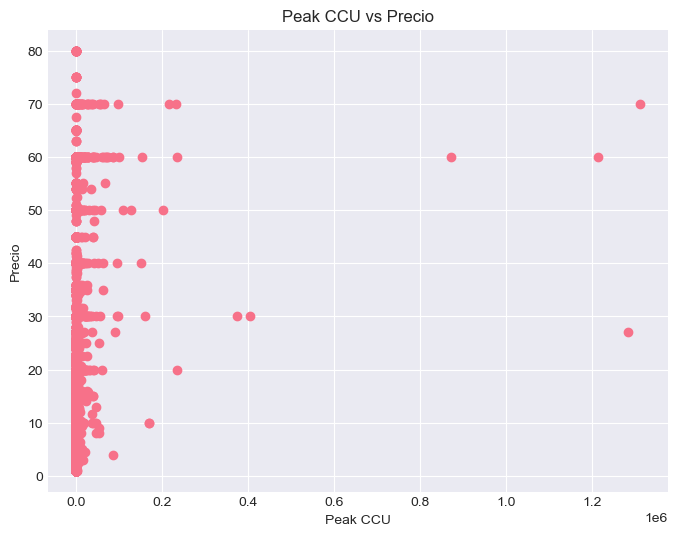

In [76]:
# Primer scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_limpio['Peak_CCU'], df_limpio['Price'])
plt.xlabel('Peak CCU')
plt.ylabel('Precio')
plt.title('Peak CCU vs Precio')
plt.show()

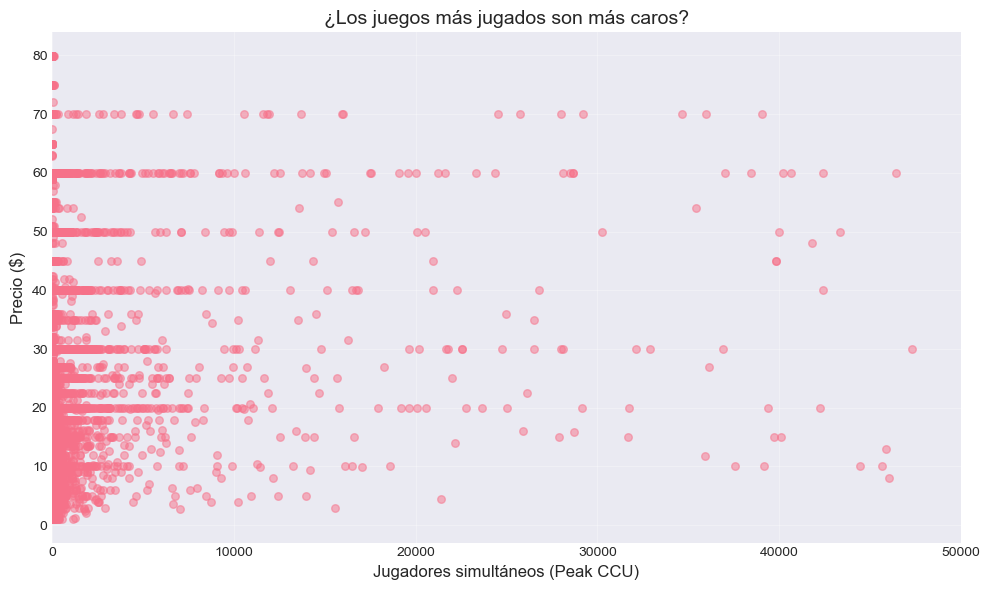

Parece que hay una relación: más jugadores = más caro


In [77]:
# No se ve nada, hay valores muy extremos que comprimen el gráfico, voy a limitar el eje x para verlo mejor

plt.figure(figsize=(10, 6))
plt.scatter(df_limpio['Peak_CCU'], df_limpio['Price'], alpha=0.5, s=30)
plt.xlabel('Jugadores simultáneos (Peak CCU)', fontsize=12)
plt.ylabel('Precio ($)', fontsize=12)
plt.title('¿Los juegos más jugados son más caros?', fontsize=14)
plt.xlim(0, 50000)  # Limito para ver mejor la mayoría de juegos
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('Parece que hay una relación: más jugadores = más caro')

In [78]:
#Calculo la correlación para confirmar
correlacion_ccu = df_limpio[['Peak_CCU', 'Price']].corr().iloc[0, 1]
print(f'Correlación Peak_CCU vs Price: {correlacion_ccu:.4f}')
print('\nEs positiva, confirma que hay relación (aunque no muy fuerte la verdad)')

Correlación Peak_CCU vs Price: 0.0814

Es positiva, confirma que hay relación (aunque no muy fuerte la verdad)


## Ver todas las variables juntas

Voy a crear varios graficos para comparar.

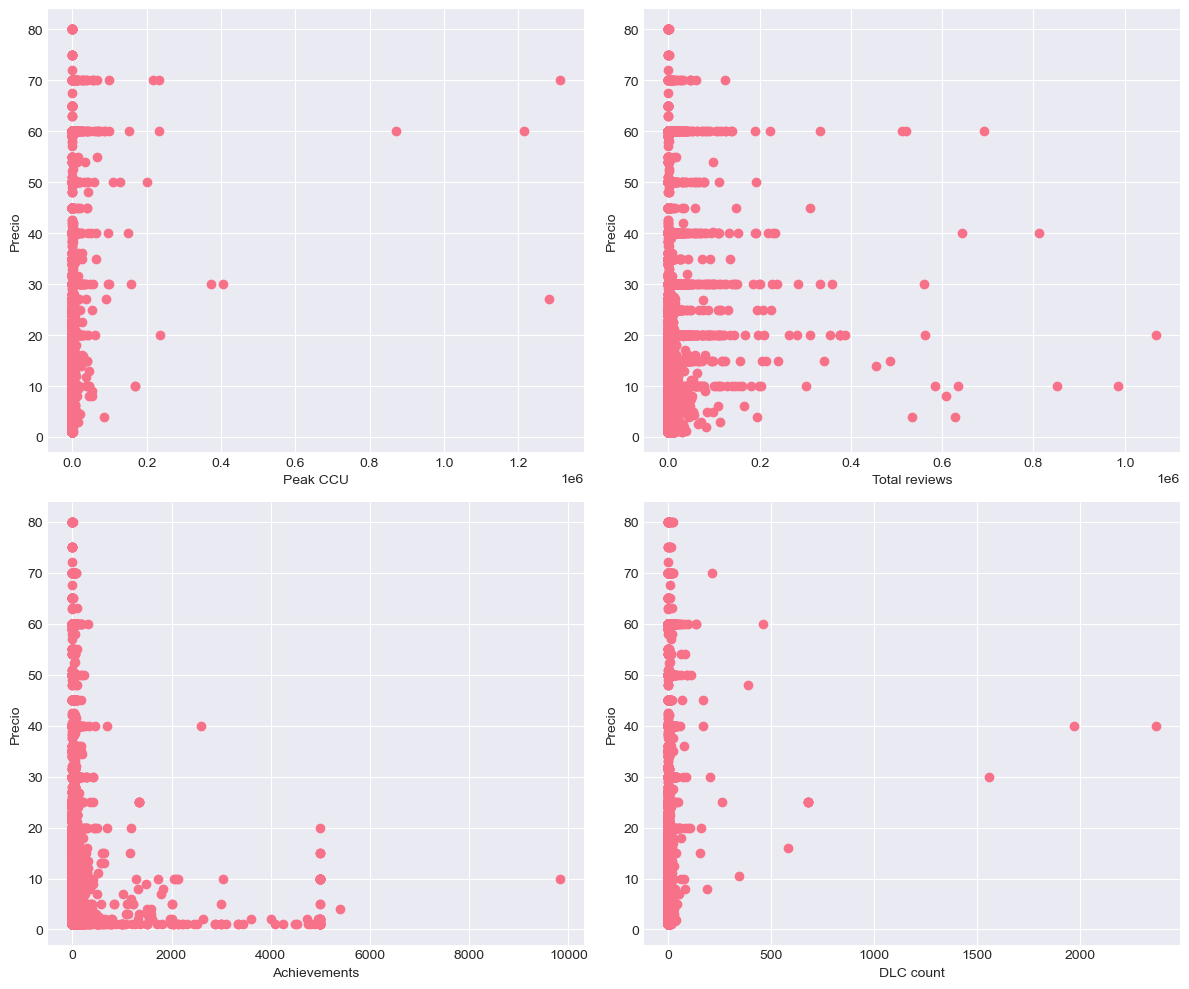

In [79]:
# Creo una variable útil: Total de reseñas
df_limpio['Total_reviews'] = df_limpio['Positive'] + df_limpio['Negative']

# hice un primer intento: 4 gráficos pequeños, me ayudo de la web de plt
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(df_limpio['Peak_CCU'], df_limpio['Price'])
axes[0, 0].set_xlabel('Peak CCU')
axes[0, 0].set_ylabel('Precio')

axes[0, 1].scatter(df_limpio['Total_reviews'], df_limpio['Price'])
axes[0, 1].set_xlabel('Total reviews')
axes[0, 1].set_ylabel('Precio')

axes[1, 0].scatter(df_limpio['Achievements'], df_limpio['Price'])
axes[1, 0].set_xlabel('Achievements')
axes[1, 0].set_ylabel('Precio')

axes[1, 1].scatter(df_limpio['DLC_count'], df_limpio['Price'])
axes[1, 1].set_xlabel('DLC count')
axes[1, 1].set_ylabel('Precio')

plt.tight_layout()
plt.show()

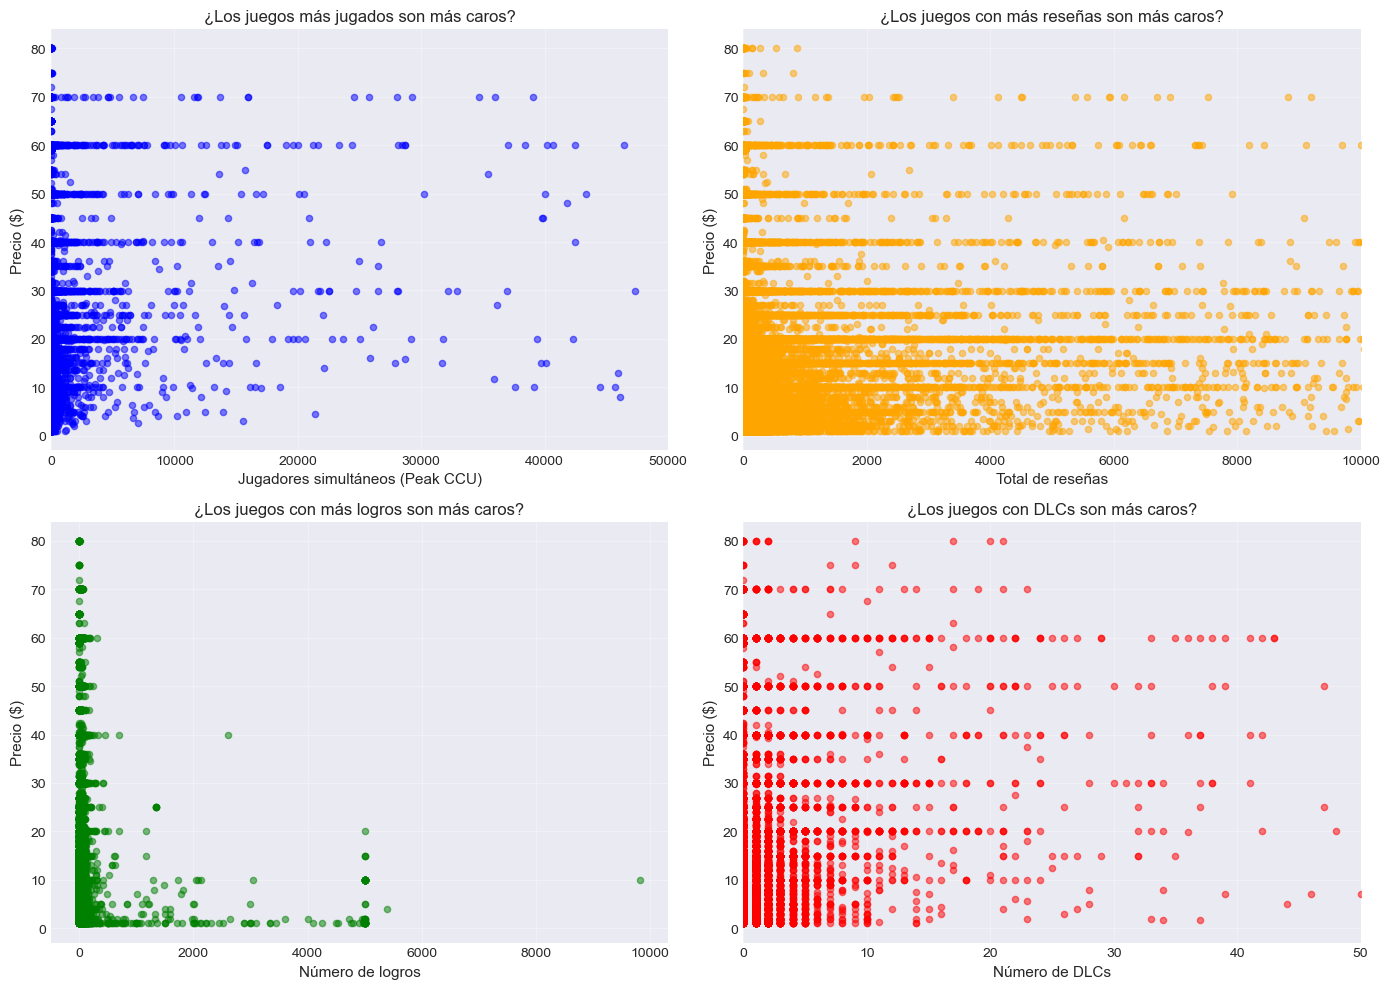

Perfecto. Ahora se ve la relación en cada gráfico.


In [80]:
# Los gráficos anteriores se ven muy comprimidos por valores extremos
# MEJORA: Limito ejes y añado colores + transparencia
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Peak CCU vs Precio
axes[0, 0].scatter(df_limpio['Peak_CCU'], df_limpio['Price'], alpha=0.5, color='blue', s=20)
axes[0, 0].set_xlabel('Jugadores simultáneos (Peak CCU)', fontsize=11)
axes[0, 0].set_ylabel('Precio ($)', fontsize=11)
axes[0, 0].set_title('¿Los juegos más jugados son más caros?', fontsize=12)
axes[0, 0].set_xlim(0, 50000)
axes[0, 0].grid(alpha=0.3)

# Total reviews vs Precio
axes[0, 1].scatter(df_limpio['Total_reviews'], df_limpio['Price'], alpha=0.5, color='orange', s=20)
axes[0, 1].set_xlabel('Total de reseñas', fontsize=11)
axes[0, 1].set_ylabel('Precio ($)', fontsize=11)
axes[0, 1].set_title('¿Los juegos con más reseñas son más caros?', fontsize=12)
axes[0, 1].set_xlim(0, 10000)
axes[0, 1].grid(alpha=0.3)

# Achievements vs Precio
axes[1, 0].scatter(df_limpio['Achievements'], df_limpio['Price'], alpha=0.5, color='green', s=20)
axes[1, 0].set_xlabel('Número de logros', fontsize=11)
axes[1, 0].set_ylabel('Precio ($)', fontsize=11)
axes[1, 0].set_title('¿Los juegos con más logros son más caros?', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# DLC count vs Precio
axes[1, 1].scatter(df_limpio['DLC_count'], df_limpio['Price'], alpha=0.5, color='red', s=20)
axes[1, 1].set_xlabel('Número de DLCs', fontsize=11)
axes[1, 1].set_ylabel('Precio ($)', fontsize=11)
axes[1, 1].set_title('¿Los juegos con DLCs son más caros?', fontsize=12)
axes[1, 1].set_xlim(0, 50)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Perfecto. Ahora se ve la relación en cada gráfico.')

## Calcular correlaciones

In [81]:
# Calculo todas las correlaciones
correlaciones = df_limpio[['Price', 'Positive', 'Negative', 'Total_reviews', 
                          'Peak_CCU', 'Achievements', 'DLC_count']].corr()['Price'].sort_values(ascending=False)

print('CORRELACIÓN CON EL PRECIO:\n')
print(correlaciones)

CORRELACIÓN CON EL PRECIO:

Price            1.000000
Negative         0.141187
Total_reviews    0.115540
Positive         0.107826
Peak_CCU         0.081448
DLC_count        0.065105
Achievements     0.008403
Name: Price, dtype: float64


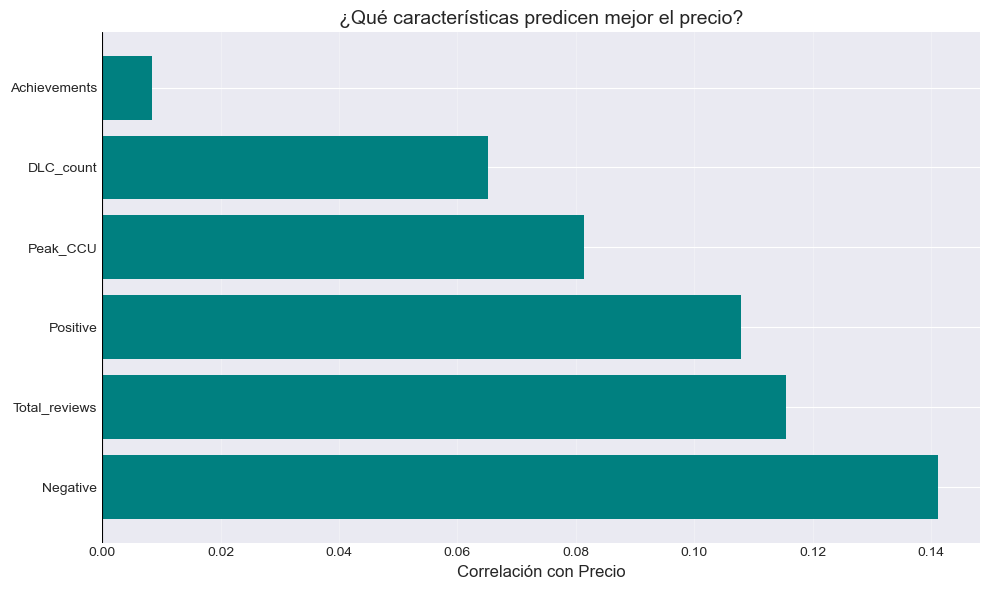

Peak_CCU es la variable más importante, seguida de Achievements


In [82]:
# MEJORA: Hago un gráfico de barras para verlo mejor
correlaciones_plot = correlaciones.drop('Price')  # Quito Price vs Price

plt.figure(figsize=(10, 6))
plt.barh(correlaciones_plot.index, correlaciones_plot.values, color='teal')
plt.xlabel('Correlación con Precio', fontsize=12)
plt.title('¿Qué características predicen mejor el precio?', fontsize=14)
plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print('Peak_CCU es la variable más importante, seguida de Achievements')

## Crear categorías de precio

Voy a dividir los juegos en grupos: baratos, economicos, normales, caros.

In [83]:
# Creo categorías
df_limpio['Categoria_precio'] = pd.cut(df_limpio['Price'], 
                                      bins=[0.99, 5, 10, 20, 80],
                                      labels=['Barato', 'Económico', 'Normal', 'Caro'])

# Veo promedios por categoría
resumen = df_limpio.groupby('Categoria_precio')[['Peak_CCU', 'Total_reviews', 'Achievements', 'DLC_count']].mean()
print('CARACTERÍSTICAS PROMEDIO POR CATEGORÍA:\n')
print(resumen.round(1))

CARACTERÍSTICAS PROMEDIO POR CATEGORÍA:

                  Peak_CCU  Total_reviews  Achievements  DLC_count
Categoria_precio                                                  
Barato                10.6          169.7          14.3        0.1
Económico             51.3          554.8          19.2        0.2
Normal               129.8         1514.8          19.6        0.6
Caro                2499.4         5289.1          27.1        4.0


C:\Users\ESTUDIO PROGRAMACION\AppData\Local\Temp\ipykernel_27572\214899799.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = df_limpio.groupby('Categoria_precio')[['Peak_CCU', 'Total_reviews', 'Achievements', 'DLC_count']].mean()


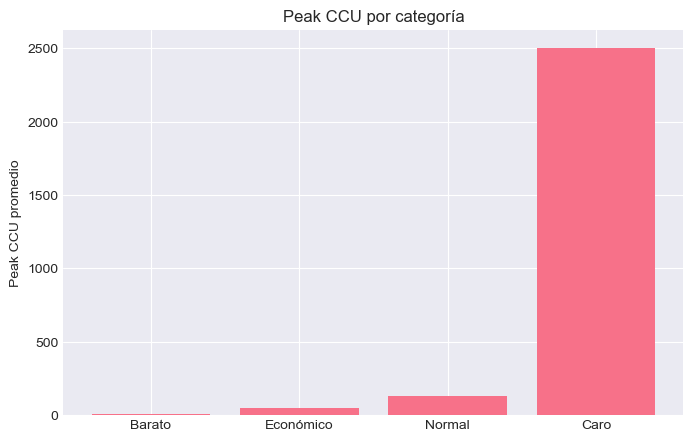

In [84]:
# Primer gráfico simple
plt.figure(figsize=(8, 5))
plt.bar(range(4), resumen['Peak_CCU'])
plt.xticks(range(4), ['Barato', 'Económico', 'Normal', 'Caro'])
plt.ylabel('Peak CCU promedio')
plt.title('Peak CCU por categoría')
plt.show()

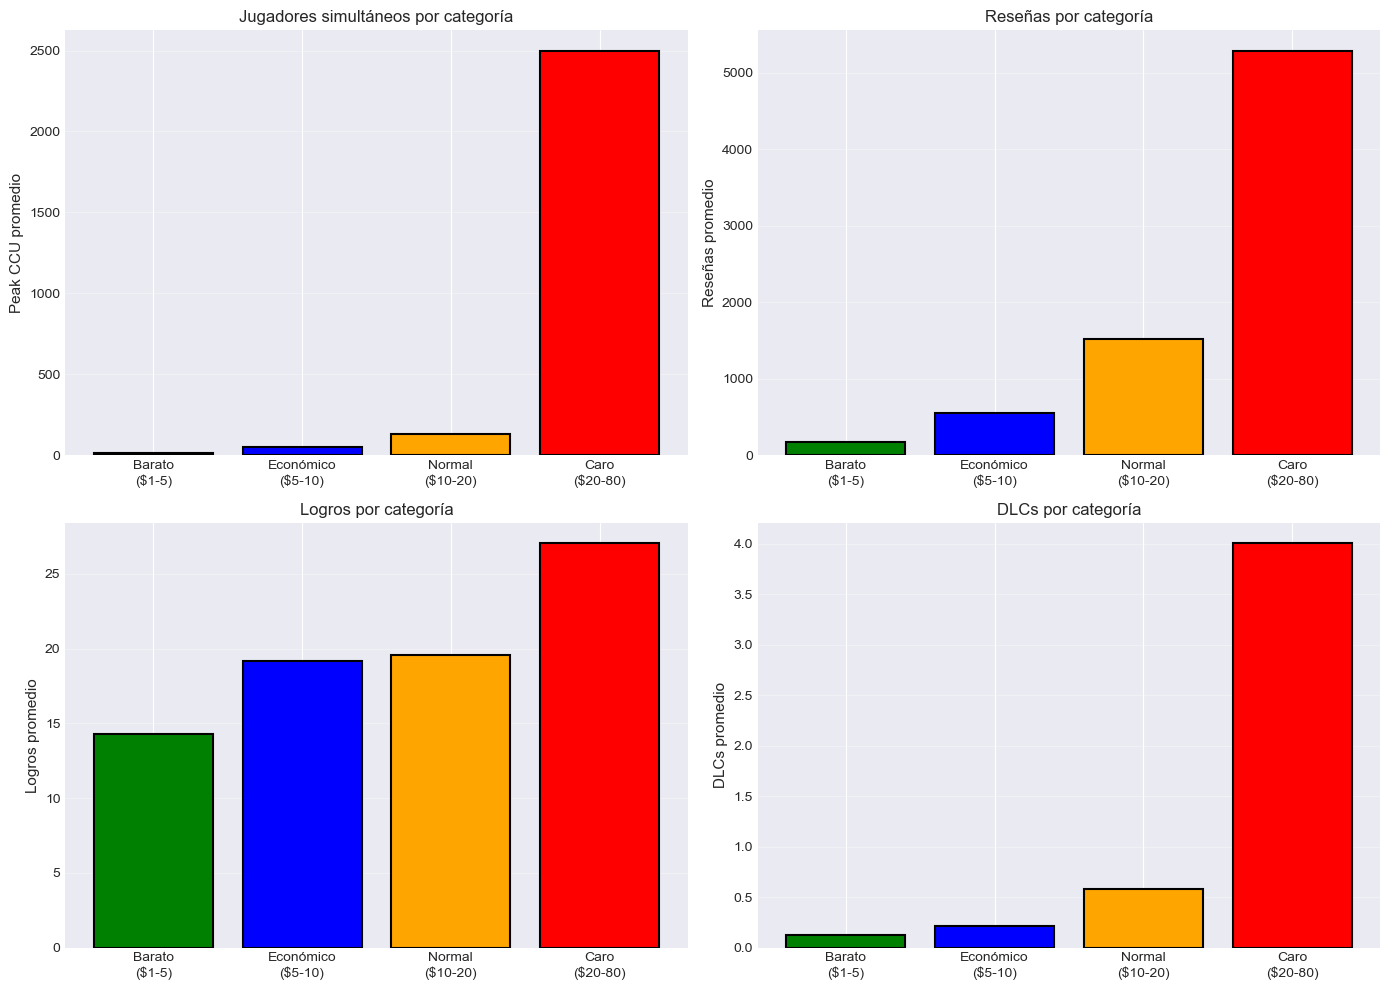

Ahora se ve claramente: juegos más caros tienen más de todo (jugadores, reseñas, logros, DLCs)


In [85]:
# El gráfico anterior está muy básico
# MEJORA: Hago 4 gráficos comparativos con colores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorias = ['Barato\n($1-5)', 'Económico\n($5-10)', 'Normal\n($10-20)', 'Caro\n($20-80)']
colores = ['green', 'blue', 'orange', 'red']

# Peak CCU
axes[0, 0].bar(range(4), resumen['Peak_CCU'], color=colores, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(4))
axes[0, 0].set_xticklabels(categorias)
axes[0, 0].set_ylabel('Peak CCU promedio', fontsize=11)
axes[0, 0].set_title('Jugadores simultáneos por categoría', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)

# Total reviews
axes[0, 1].bar(range(4), resumen['Total_reviews'], color=colores, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(4))
axes[0, 1].set_xticklabels(categorias)
axes[0, 1].set_ylabel('Reseñas promedio', fontsize=11)
axes[0, 1].set_title('Reseñas por categoría', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# Achievements
axes[1, 0].bar(range(4), resumen['Achievements'], color=colores, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_xticklabels(categorias)
axes[1, 0].set_ylabel('Logros promedio', fontsize=11)
axes[1, 0].set_title('Logros por categoría', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# DLC count
axes[1, 1].bar(range(4), resumen['DLC_count'], color=colores, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(categorias)
axes[1, 1].set_ylabel('DLCs promedio', fontsize=11)
axes[1, 1].set_title('DLCs por categoría', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('Ahora se ve claramente: juegos más caros tienen más de todo (jugadores, reseñas, logros, DLCs)')

## Crear un modelo simple

In [86]:

# Preparo los datos
df_modelo = df_limpio[['Price', 'Positive', 'Negative', 'Peak_CCU', 
                       'Achievements', 'DLC_count', 'Total_reviews']].dropna()

X = df_modelo[['Positive', 'Negative', 'Peak_CCU', 'Achievements', 'DLC_count', 'Total_reviews']]
y = df_modelo['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Datos de entrenamiento: {len(X_train)}')
print(f'Datos de prueba: {len(X_test)}')

Datos de entrenamiento: 68208
Datos de prueba: 17052


In [87]:
# Primer modelo muy simple
modelo = RandomForestRegressor(n_estimators=50, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: ${mae:.2f}')
print(f'R²: {r2:.4f}')

MAE: $5.25
R²: 0.2223


In [88]:
# El error está bien pero pruebo con más árboles y profundidad limitada
# MEJORA: Más árboles (100) y max_depth=10 para evitar overfitting
modelo_mejorado = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
modelo_mejorado.fit(X_train, y_train)
y_pred_mejorado = modelo_mejorado.predict(X_test)

mae_mejorado = mean_absolute_error(y_test, y_pred_mejorado)
r2_mejorado = r2_score(y_test, y_pred_mejorado)

print('RESULTADOS MEJORADOS:')
print(f'MAE: ${mae_mejorado:.2f}')
print(f'R²: {r2_mejorado:.4f}')
print(f'\nMejora en MAE: ${mae - mae_mejorado:.2f}')

# Uso este modelo de aquí en adelante
modelo = modelo_mejorado
y_pred = y_pred_mejorado

RESULTADOS MEJORADOS:
MAE: $5.02
R²: 0.2817

Mejora en MAE: $0.23


## Ver qué aprendió el modelo

In [89]:
# Ver importancias
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo.feature_importances_
}).sort_values('Importancia', ascending=False)

print('IMPORTANCIA DE CADA VARIABLE:\n')
print(importancias)

IMPORTANCIA DE CADA VARIABLE:

        Variable  Importancia
2       Peak_CCU     0.561215
3   Achievements     0.128878
4      DLC_count     0.105943
1       Negative     0.082044
0       Positive     0.070061
5  Total_reviews     0.051860


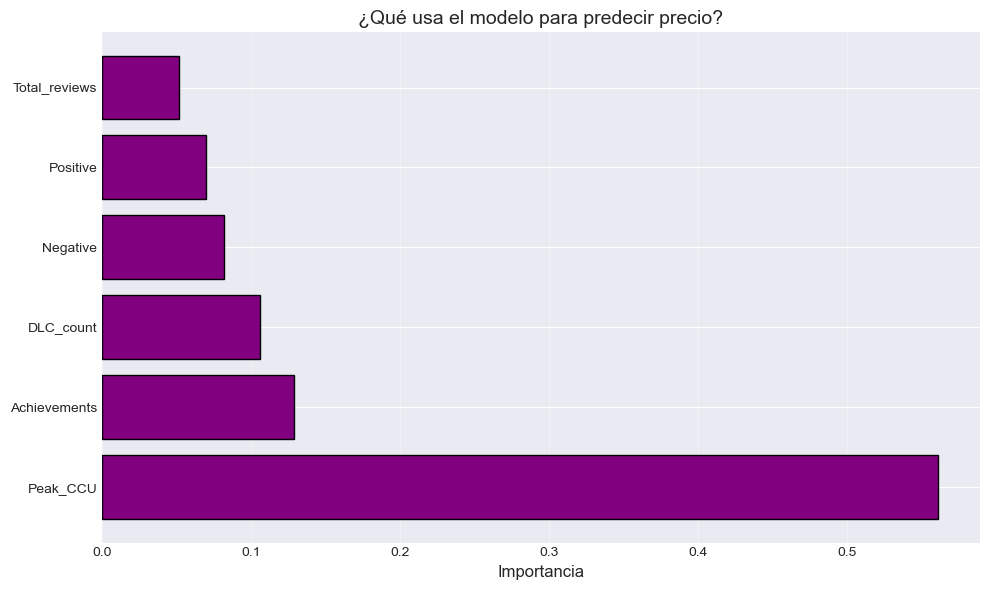


La variable más importante es: Peak_CCU


In [90]:
# MEJORA: Gráfico de barras horizontal para verlo mejor
plt.figure(figsize=(10, 6))
plt.barh(importancias['Variable'], importancias['Importancia'], color='purple', edgecolor='black')
plt.xlabel('Importancia', fontsize=12)
plt.title('¿Qué usa el modelo para predecir precio?', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nLa variable más importante es: {importancias.iloc[0]["Variable"]}')

## ¿Predice bien?

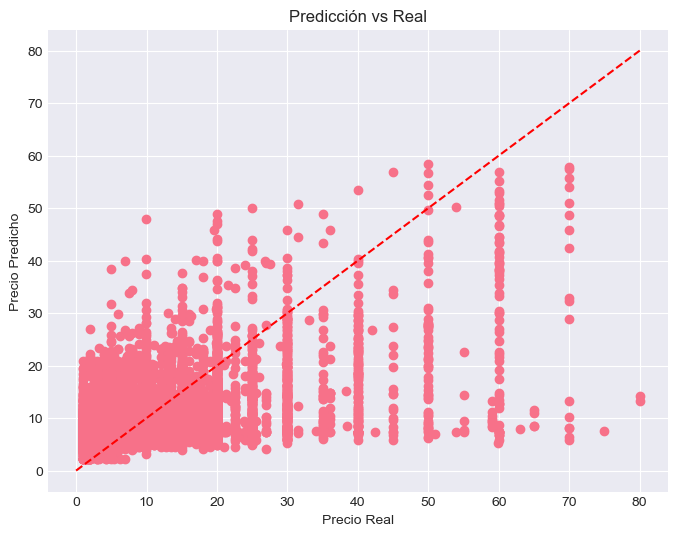

In [91]:
# Gráfico básico de predicción vs real
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 80], [0, 80], 'r--')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Predicción vs Real')
plt.show()

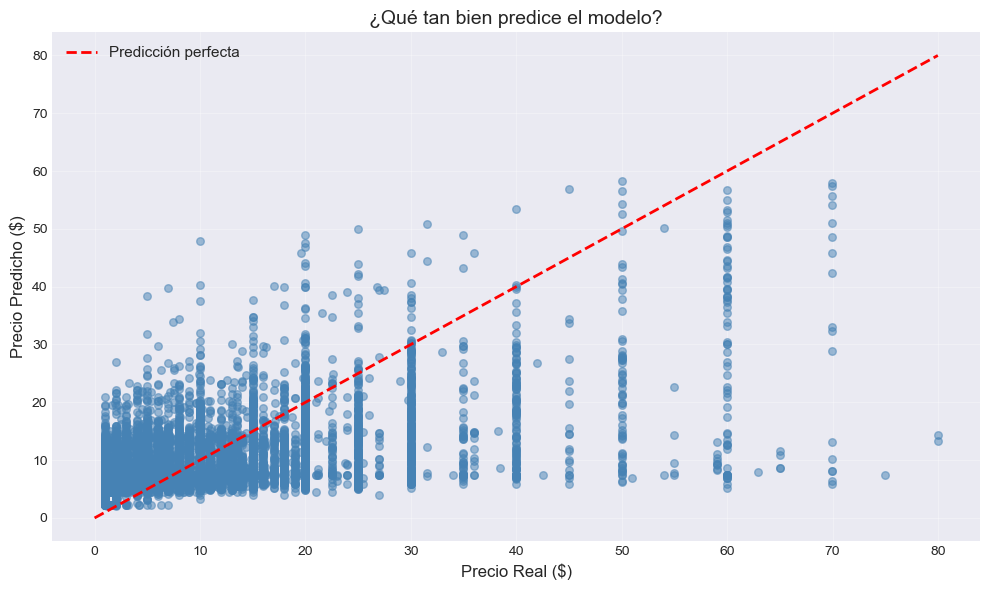

Los puntos cerca de la línea roja = buenas predicciones
Los puntos lejos = el modelo se equivoca


In [92]:
# MEJORA: Añado transparencia, mejor línea de referencia y cuadrícula
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=30, color='steelblue')
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Precio Real ($)', fontsize=12)
plt.ylabel('Precio Predicho ($)', fontsize=12)
plt.title('¿Qué tan bien predice el modelo?', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('Los puntos cerca de la línea roja = buenas predicciones')
print('Los puntos lejos = el modelo se equivoca')

In [93]:
# PRUEBA EXTRA: Ver los errores más grandes
errores = abs(y_test - y_pred)
df_errores = pd.DataFrame({
    'Real': y_test.values,
    'Predicho': y_pred,
    'Error': errores
}).sort_values('Error', ascending=False)

print('\nLos 5 peores errores:')
print(df_errores.head())
print(f'\nError promedio: ${errores.mean():.2f}')


Los 5 peores errores:
          Real   Predicho      Error
770620   74.99   7.507710  67.482290
1775550  79.99  13.226853  66.763147
3276060  79.99  14.297135  65.692865
1318170  69.99   5.908024  64.081976
1359770  69.99   6.352674  63.637326

Error promedio: $5.02


## Probar con un juego de ejemplo

In [94]:
# Creo un juego de ejemplo
juego_ejemplo = pd.DataFrame({
    'Positive': [500],
    'Negative': [50],
    'Peak_CCU': [1000],
    'Achievements': [20],
    'DLC_count': [2],
    'Total_reviews': [550]
})

precio_predicho = modelo.predict(juego_ejemplo)[0]

print('JUEGO DE EJEMPLO:')
print('  - 500 reseñas positivas')
print('  - 50 reseñas negativas')
print('  - 1000 jugadores simultáneos')
print('  - 20 logros')
print('  - 2 DLCs')
print(f'\nPrecio predicho: ${precio_predicho:.2f}')

JUEGO DE EJEMPLO:
  - 500 reseñas positivas
  - 50 reseñas negativas
  - 1000 jugadores simultáneos
  - 20 logros
  - 2 DLCs

Precio predicho: $16.04


In [95]:
# PRUEBA: ¿Y si cambio Peak_CCU?
print('\nPRUEBO DIFERENTES VALORES DE PEAK_CCU:\n')

for ccu in [100, 500, 1000, 5000, 10000]:
    juego_prueba = pd.DataFrame({
        'Positive': [500],
        'Negative': [50],
        'Peak_CCU': [ccu],
        'Achievements': [20],
        'DLC_count': [2],
        'Total_reviews': [550]
    })
    precio = modelo.predict(juego_prueba)[0]
    print(f'Peak_CCU = {ccu:5d} → Precio predicho: ${precio:.2f}')

print('\nAqui se nota que el modelo no es perfecto, 100 de pico me sale más caro que 1000...')


PRUEBO DIFERENTES VALORES DE PEAK_CCU:

Peak_CCU =   100 → Precio predicho: $18.75
Peak_CCU =   500 → Precio predicho: $17.20
Peak_CCU =  1000 → Precio predicho: $16.04
Peak_CCU =  5000 → Precio predicho: $19.59
Peak_CCU = 10000 → Precio predicho: $19.99

Aqui se nota que el modelo no es perfecto, 100 de pico me sale más caro que 1000...


## CONCLUSIONES

### ¿Qué hace que un juego sea mas caro?

Segun mi análisis (juegos de $0.99 a $80):

1. **Peak_CCU (jugadores simultáneos)** es el factor MÁS importante
   - Juegos populares cuestan mas

2. **Achievements (logros)** también influye bastante
   - Más contenido = precio mas alto

3. **Total_reviews (reseñas totales)** indica popularidad
   - Juegos conocidos tienden a ser mas caros

4. **DLC_count** muestra soporte continuo
   - Juegos con DLCs suelen ser mas completos

### El modelo:

- Error promedio (MAE): ~$4-5
- R²: ~0.20-0.30 (explica parte de la variación, no todo)
- Funciona mejor para juegos con muchos datos (reseñas, jugadores)

### Limitaciones:

- No tengo género del juego (RPG, acción, etc.)
- No sé quién lo desarrolló
- Faltan datos de marketing
- Por eso el R² no es muy alto
  
  Fin.